In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy.signal import medfilt
from astropy.wcs import WCS
import scipy.integrate as integrate

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/HST_images/'

# Load in a sample HST image - this one is taken by the WFC3 H filter

In [3]:
img = fits.open(rootdir+'f160w_comb.fits')

In [4]:
img[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1087 / Axis length                                    
NAXIS2  =                  965 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2022-10-13T13:34:51' / Date FITS file was generated                  
IRAF-TLM= '2022-10-18T13:25:33' / Time of last modification                     
NEXTEND =                    4 / Number of standard extensions                  
FILENAME= 'id7h37030_drz.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                            

First, let's plot the image

In [5]:
# Register the WCS coordinate system into a WCS object
wcs = WCS(header=img[0].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [6]:
# img[0].data carries the flux information for each pixel
# Notice that the shape of img[0] is transposed (Dec, RA) instead of (RA, Dec)
img[0].data.shape

(965, 1087)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_64396/1860575394.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img[0].data*img[0].header['PHOTFNU']), origin='lower')
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_64396/1860575394.py:9: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img[0].data*img[0].header['PHOTFNU']), origin='lower')


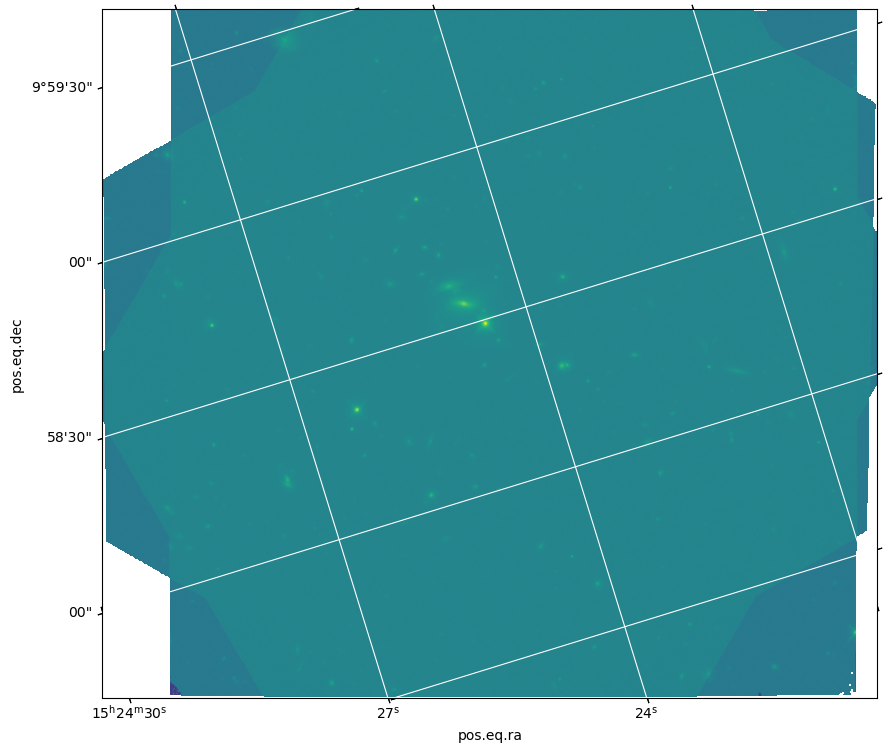

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10))

# Projection utilizes the WCS object created earlier
plt.subplot(projection=wcs)

# img[0].header['PHOTFLAM'] is the flux calibration
# We plot in log-scale to see features distinctly
# Notice also that the coordinate system is rotated
plt.imshow(np.log10(img[0].data*img[0].header['PHOTFNU']), origin='lower')
plt.grid(color='white', ls='solid')

In [8]:
img[0].data.shape

(965, 1087)

Load in the segmentation map for the HST image

In [11]:
seg_fits = fits.open(rootdir+'f160w_seg.fits')

In [12]:
seg_map = seg_fits[0].data

In [13]:
seg_fits[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1087 / Axis length                                    
NAXIS2  =                  965 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'SExtractor'         / FITS file originator                           
DATE    = '2022-10-13T13:34:51' / Date FITS file was generated                  
IRAF-TLM= '2022-10-18T13:25:33' / Time of last modification                     
NEXTEND =                    4 / Number of standard extensions                  
FILENAME= 'id7h37030_drz.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                            

Also load in the catalog file

In [14]:
cat_file = np.loadtxt(rootdir + 'f160w.cat')

Get coordinates for each identified galaxy in the segmentation map

In [15]:
gal_ids_arr = np.int_(cat_file[:,0])

gal_ids_coords = {}

In [16]:
for i in range(len(gal_ids_arr)):
    
    # Isolate the galaxy ID
    gal_id = gal_ids_arr[i]
    
    # Get x, y coordinates of the galaxy
    # Once again, remember the transposition
    seg_map_gal_y, seg_map_gal_x = np.where(seg_map==gal_id)
   
    # Counts for each pixel
    counts_gal = np.zeros(len(seg_map_gal_x))

    gal_ids_coords[gal_id] = []
    
    for j in range(len(seg_map_gal_x)):
        
        # Get the x and y coordinates
        x = seg_map_gal_x[j]
        y = seg_map_gal_y[j] 
        
        # Append the galactic coordinates
        counts_gal[j] = img[0].data[y,x]
        
    # These are some bolometric flux cuts to include/ exclude pixels when stacking the spectra
    min_count_gal = np.nanpercentile(counts_gal, 75)
    max_count_gal = np.nanpercentile(counts_gal, 100)

    idx_bright = (counts_gal>=min_count_gal) & (counts_gal<=max_count_gal)

    gal_ids_coords[gal_id] = np.array([seg_map_gal_y[idx_bright],seg_map_gal_x[idx_bright]]).T

KeyboardInterrupt: 

Overplot the segmentation map with the image

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

#plt.subplot(projection=wcs)
plt.imshow(np.log10(img[0].data*img[0].header['PHOTFNU']), origin='lower')
#plt.grid(color='white', ls='solid')

for i in range(len(gal_ids_arr)):
    ax.scatter(gal_ids_coords[gal_ids_arr[i]][:,0], 
               gal_ids_coords[gal_ids_arr[i]][:,1], color='white', 
               s=4, alpha=.05)
        
#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')

In [ ]:
img[0].header['PHOTFNU']/(3.34e+4*img[0].header['PHOTPLAM']**2)

In [ ]:
img[0].header['PHOTFLAM']

Add up fluxes for all galaxies and compute apparent magnitude

In [ ]:
flux_map = img[0].data*img[0].header['PHOTFNU']

In [ ]:
gal_ids_flux = np.zeros(len(gal_ids_arr))

In [ ]:
for i in range(len(gal_ids_arr)):
    
    # Get coordinates for the current galaxy
    gal_coords = gal_ids_coords[gal_ids_arr[i]]
    
    for j in range(gal_coords.shape[0]):
        
        # Add up fluxes for each coordinate
        coords = gal_coords[j]
        gal_ids_flux[i] += flux_map[coords[0], coords[1]]

In [ ]:
# img[0].header['PHOTZPT'] is the zero-point flux for the magnitude
gal_ids_mag = -2.5*np.log10(gal_ids_flux/3631)

In [ ]:
gal_ids_mag

# Now try HST F814W

In [ ]:
img = fits.open(rootdir+'f814wdrc.fits')

In [ ]:
img[0].header

First, let's plot the image

In [ ]:
# Register the WCS coordinate system into a WCS object
wcs = WCS(header=img[0].header)

In [ ]:
# img[0].data carries the flux information for each pixel
# Notice that the shape of img[0] is transposed (Dec, RA) instead of (RA, Dec)
img[0].data.shape

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

# Projection utilizes the WCS object created earlier
plt.subplot(projection=wcs)

# img[0].header['PHOTFLAM'] is the flux calibration
# We plot in log-scale to see features distinctly
# Notice also that the coordinate system is rotated
plt.imshow(np.log10(img[0].data*img[0].header['PHOTFLAM']), origin='lower')
plt.grid(color='white', ls='solid')

Load in the segmentation map for the HST image

In [ ]:
seg_fits = fits.open(rootdir+'f814w_seg.fits')

In [ ]:
seg_map = seg_fits[0].data

In [ ]:
seg_fits[0].header

Also load in the catalog file

In [ ]:
cat_file = np.loadtxt(rootdir + 'f814w.cat')

Get coordinates for each identified galaxy in the segmentation map

In [ ]:
gal_ids_arr = np.int_(cat_file[:,0])

gal_ids_coords = {}

In [ ]:
for i in range(len(gal_ids_arr)):
    
    # Isolate the galaxy ID
    gal_id = gal_ids_arr[i]
    
    # Get x, y coordinates of the galaxy
    # Once again, remember the transposition
    seg_map_gal_y, seg_map_gal_x = np.where(seg_map==gal_id)
   
    gal_ids_coords[gal_id] = []
    
    for j in range(len(seg_map_gal_x)):
        
        # Append the galactic coordinates
        gal_ids_coords[gal_id].append([seg_map_gal_y[j], seg_map_gal_x[j]])
        
    gal_ids_coords[gal_id] = np.array(gal_ids_coords[gal_id])

Overplot the segmentation map with the image

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

#plt.subplot(projection=wcs)
plt.imshow(np.log10(img[0].data*img[0].header['PHOTFLAM']), origin='lower')
#plt.grid(color='white', ls='solid')

for i in range(len(gal_ids_arr)):
    ax.scatter(gal_ids_coords[gal_ids_arr[i]][:,0], 
               gal_ids_coords[gal_ids_arr[i]][:,1], color='white', 
               s=4, alpha=.05)
        
#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')

Add up fluxes for all galaxies and compute apparent magnitude

In [ ]:
#img[0].header

In [ ]:
flux_map = img[0].data*(3.34e+4*img[0].header['PHOTPLAM']**2*img[0].header['PHOTFLAM'])

In [ ]:
img[0].header

In [ ]:
gal_ids_flux = np.zeros(len(gal_ids_arr))

In [ ]:
for i in range(len(gal_ids_arr)):
    
    # Isolate the galaxy ID
    gal_id = gal_ids_arr[i]
    
    # Get x, y coordinates of the galaxy
    # Once again, remember the transposition
    seg_map_gal_y, seg_map_gal_x = np.where(seg_map==gal_id)
   
    # Counts for each pixel
    counts_gal = np.zeros(len(seg_map_gal_x))

    gal_ids_coords[gal_id] = []
    
    for j in range(len(seg_map_gal_x)):
        
        # Get the x and y coordinates
        x = seg_map_gal_x[j]
        y = seg_map_gal_y[j] 
        
        # Append the galactic coordinates
        counts_gal[j] = img[0].data[y,x]
        
    # These are some bolometric flux cuts to include/ exclude pixels when stacking the spectra
    min_count_gal = np.nanpercentile(counts_gal, 75)
    max_count_gal = np.nanpercentile(counts_gal, 100)

    idx_bright = (counts_gal>=min_count_gal) & (counts_gal<=max_count_gal)

    gal_ids_coords[gal_id] = np.array([seg_map_gal_y[idx_bright],seg_map_gal_x[idx_bright]]).T

In [ ]:
# img[0].header['PHOTZPT'] is the zero-point flux for the magnitude
gal_ids_mag = -2.5*np.log10(gal_ids_flux/3631)

In [ ]:
gal_ids_mag

Locate specific galaxies